In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import time
import os
import copy
import h5py
import sys
import torch
from PIL import Image
import gc

sys.path.append('../code')

from python.finetune_commons import show_images, ft_train_model, visualize_model
from python.commons import load_dict_from_hdf5, save_dict_to_hdf5, inc_inference_e2e, full_inference_e2e, adaptive_drilldown, generate_heatmap
from python.vgg16 import VGG16

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
torch.manual_seed(183)
np.random.seed(183)

data_dir = '../data/chest_xray/BACTERIAL_NORMAL'

n_labels = 2

In [3]:
transform = transforms.Compose([
        transforms.Resize(224),
        #transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

        #imagenet
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        #bone
        #transforms.Normalize([0.18805075, 0.18805075, 0.18805075], [0.1892409, 0.1892409, 0.1892409])
        
        #chest
        #transforms.Normalize([0.5709945, 0.5709945, 0.5709945], [0.1767184, 0.1767184, 0.1767184])
        
        #oct
        #transforms.Normalize([0.1930184, 0.1930184, 0.1930184], [0.21612172, 0.21612172, 0.21612172])
    ])
    
    
data_transforms = {'train': transform, 'validation': transform}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                        shuffle=True, num_workers=4) for x in ['train', 'validation']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['BACTERIAL', 'NORMAL']


### VGG16

In [5]:
model_ft = models.vgg16(pretrained=True)
model_ft = model_ft.eval()
for param in model_ft.features.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.classifier[-1].in_features
temp = list(model_ft.classifier.children())[:-1]
temp.append(nn.Linear(num_ftrs, n_labels))
temp.append(nn.Softmax(dim=1))
model_ft.classifier = nn.Sequential(*temp)

for param in model_ft.classifier[0:-2].parameters():
    param.requires_grad = False

    
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.classifier[-2].parameters(), lr=1e-3)#, weight_decay=1e-8)

In [6]:
model_ft = ft_train_model(model_ft, criterion, optimizer_ft, dataloaders, device,
                          dataset_sizes, class_names, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5945 Acc: 0.6866
validation Loss: 0.5082 Acc: 0.8462
Epoch 1/4
----------
train Loss: 0.4723 Acc: 0.8631
validation Loss: 0.4548 Acc: 0.8665
Epoch 2/4
----------
train Loss: 0.4397 Acc: 0.8756
validation Loss: 0.4351 Acc: 0.8761
Epoch 3/4
----------
train Loss: 0.4267 Acc: 0.8892
validation Loss: 0.4252 Acc: 0.8921
Epoch 4/4
----------
train Loss: 0.4160 Acc: 0.9044
validation Loss: 0.4182 Acc: 0.8964
Training complete in 0m 46s
Best validation Acc: 0.896368


In [6]:
# final_layer = {}
# final_layer['fc8_W:0'] = model_ft.classifier[-2].weight.data.cpu().numpy()
# final_layer['fc8_b:0'] = model_ft.classifier[-2].bias.data.cpu().numpy()
# save_dict_to_hdf5(final_layer, './chest_bacterial_vgg16_ptch.h5')

temp_weights_data = load_dict_from_hdf5('chest_bacterial_vgg16_ptch.h5', gpu=True)
model_ft.classifier[-2].weight.data = temp_weights_data['fc8_W:0']
model_ft.classifier[-2].bias.data = temp_weights_data['fc8_b:0']

In [7]:
#file_path = '../data/chest_xray/validation/NORMAL/IM-0003-0001.jpeg'
#file_path = '../data/chest_xray/validation/VIRAL/person530_virus_1052.jpeg'
file_path = '../data/chest_xray/BACTERIAL_NORMAL/validation/BACTERIAL/person133_bacteria_633.jpeg'

In [8]:
print(model_ft(data_transforms['validation'](Image.open(file_path).convert('RGB')).unsqueeze(0).cuda()))

tensor([[ 0.9966,  0.0034]], device='cuda:0')


In [9]:
weights_data = load_dict_from_hdf5('../code/python/vgg16_weights_ptch.h5', gpu=True)
weights_data['fc8_W:0'] = model_ft.classifier[-2].weight.data
weights_data['fc8_b:0'] = model_ft.classifier[-2].bias.data

In [18]:
patch_size = 4
stride = 4
logit_index= 0

In [19]:
gc.collect()
torch.cuda.empty_cache()

In [20]:
# prev_time = time.time()
# x, prob, logit_index = full_inference_e2e(VGG16, file_path, patch_size, stride, logit_index, batch_size=128, n_labels=2,
#                        weights_data=weights_data, loader=data_transforms['validation'])
# print('Runtime: ' + str((time.time()-prev_time)) + " s")
# orig_hm = generate_heatmap(file_path, x, show=True, label=class_names[logit_index], prob=prob)

In [21]:
gc.collect()
torch.cuda.empty_cache()

Runtime: 2.23918604851 s


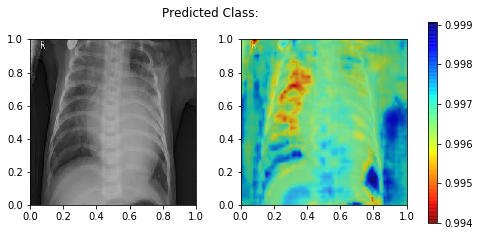

Runtime: 2.24944281578 s


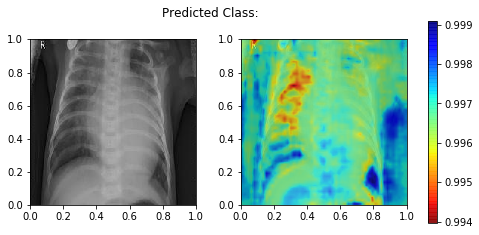

Runtime: 2.13367700577 s


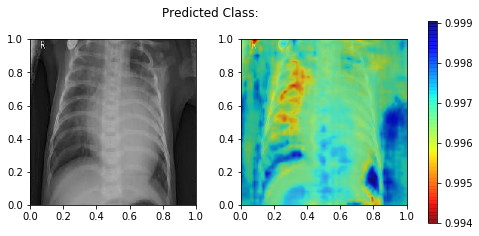

In [22]:
for b in [0.5, 0.4, 0.25]:
    prev_time = time.time()
    x, prob, logit_index = inc_inference_e2e(VGG16, file_path, patch_size, stride, logit_index, batch_size=128, beta=b,
                          x0=0, y0=0, image_size=224,
                          x_size=224, y_size=224, gpu=True, n_labels=2,
                          weights_data=weights_data, loader=data_transforms['validation'], c=0.5)

    print('Runtime: ' + str((time.time()-prev_time)) + " s")
    hm_th = generate_heatmap(file_path, x, show=True, label=class_names[logit_index], prob=prob)

In [23]:
gc.collect()
torch.cuda.empty_cache()

Runtime: 2.10696601868 s


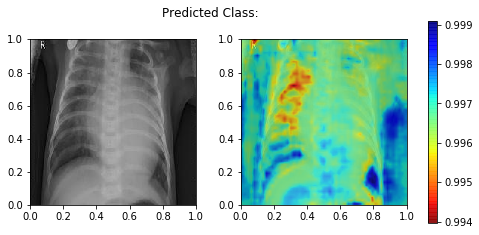

In [25]:
prev_time = time.time()
x, prob, logit_index = inc_inference_e2e(VGG16, file_path, patch_size, stride, logit_index, batch_size=256,
                      beta=0.4, n_labels=2, weights_data=weights_data, loader=data_transforms['validation'], c=0.5)
print('Runtime: ' + str((time.time()-prev_time)) + " s")
hm_th = generate_heatmap(file_path, x, show=True, label=class_names[logit_index], prob=prob)

In [28]:
print("SSIM Index: " + str(ssim(orig_hm, hm_th, data_range=255, multichannel=True)))

SSIM Index: 0.9860328495831397


In [29]:
gc.collect()
torch.cuda.empty_cache()

Runtime: 22.0770521164 s


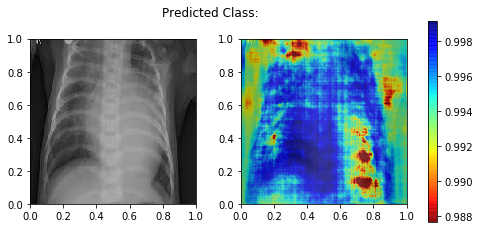

In [30]:
prev_time = time.time()
x, prob, logit_index = adaptive_drilldown(VGG16, file_path, patch_size, stride, logit_index,
                   batch_size=256, image_size=224, beta=1.0, percentile=10, gpu=True, n_labels=2, weights_data=weights_data)
print('Runtime: ' + str((time.time()-prev_time)) + " s")
hm_adaptive = generate_heatmap(file_path, x, show=True, label=class_names[logit_index], prob=prob)

In [31]:
print("SSIM Index: " + str(ssim(orig_hm, hm_adaptive, data_range=255, multichannel=True)))

SSIM Index: 0.9944871254746342
